# Notes
- Either use this or the copy but create a train/test split & figur eout where are the error metrics are being created!!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Importing the datasets that will be used
train_set = pd.read_csv("./archive/train.csv")
test_set = pd.read_csv("./archive/test.csv")

# Creating a column to label the train_set & test_set
train_set['data_source'] = "train_set"
test_set['data_source'] = "test_set"

In [3]:
# Adding the missing columns for the testing columns
test_set['count'] = np.nan
test_set['registered'] = np.nan
test_set['casual'] = np.nan

In [4]:
# Concatenating the train_set with the test_set
data = pd.concat([train_set, test_set], axis=0, sort=False)

# Lowercase column names
data.columns = map(str.lower, data.columns)

data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_source
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,train_set
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,train_set
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,train_set
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,train_set
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,train_set


In [5]:
print(f'Train set cols. {", ".join(train_set.columns.tolist())}')
print(f'Test set cols. {", ".join(test_set.columns.tolist())}')
print(f'Difference cols. are {set(train_set.columns) - set(test_set.columns)}')

Train set cols. datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count, data_source
Test set cols. datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, data_source, count, registered, casual
Difference cols. are set()


#### Notes:
Notice that we have three potential target variables. While the count is the exact predictor, we could calculate the casual and registerd to find the count... we'll see how we will calculate the predictor.

In [6]:
# Let's look at the datatype
data.dtypes.sort_values()

season           int64
holiday          int64
workingday       int64
weather          int64
humidity         int64
temp           float64
atemp          float64
windspeed      float64
casual         float64
registered     float64
count          float64
datetime        object
data_source     object
dtype: object

In [7]:
print(f"Total observation (train_set): {train_set.shape[0]}")
print(f"Total observation (test_set): {test_set.shape[0]}")

Total observation (train_set): 10886
Total observation (test_set): 6493


#### Notes:
- The date variable is an object so you will have to change it to a datetype

## Data Cleaning

In [8]:
# Interpolate weather, atemp, humidity
data["weather"] = data["weather"].interpolate(method='time').apply(np.round)
data["temp"] = data["temp"].interpolate(method='time')
data["atemp"] = data["atemp"].interpolate(method='time')
data["humidity"] = data["humidity"].interpolate(method='time').apply(np.round)
data["windspeed"] = data["windspeed"].interpolate(method='time')

In [9]:
def get_dtypes(data, verbose=False):
    """Returns a list: numerical values, object-like columns"""
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics_cols = data.select_dtypes(include=numerics).columns
    object_cols = data.select_dtypes(include='object').columns
    if verbose:
        print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
              (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
    return [numerics_cols, object_cols]

def get_missing_values(data, cols):
    """Returns a dataframe with missing values (in absolute and percentage format)"""
    
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    
    # Removing zero values
    df = df.loc[~(df==0).all(axis=1)]
    return df

In [10]:
# Separting the numeric and object columnac
num_cols, obj_cols = get_dtypes(data, verbose=False)

# Calculating missing values in our data
missing = get_missing_values(data, num_cols)
missing

,Missing,Percent
count,6493,0.373612
registered,6493,0.373612
casual,6493,0.373612


#### Notes:
- The only missing values is from the predictors... which is reasonable!

## Feature Enginnering

#### Notes:
- `extract_dateinfo` function is a fast.ai function. 
    - From a date datatype, it is able to make many calculations!
    - It automates the feature engineering processs.
- `custom_datainfo` function is a function I created.
    - It focuses on renaming or creating abritrary columns (like rush_hour)

In [11]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, start_ref=pd.datetime(1900, 1, 1), extra_attr = True):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [12]:
# Calculating various date variables
data = extract_dateinfo(data, 'datetime', drop=False, time=True)

In [13]:
import calendar

# Conditional on time of day: morning=1, afternoon=2, evening=3, night=4
# Conditional on time of day: spring=1, summer=2, fall=3, winter=4
# Conditional on time of day: clear/few clouds=1, light snow/light rain=2, 
#                             light snow/light rain=3, heavy rain/ice pallets=4

def custom_dateinfo(data):
    data = data.copy()
    data['Year'] = data['Year'].astype('object')
    data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
    
    dayofweek_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    data['Dayofweek'] = data['Dayofweek'].map(dayofweek_name)
    data['Weekofyear'] = data['datetime'].dt.weekofyear
    data['Weekend'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [5,6]) else "No")
    
    # Creatinga new column that identifies the time of the day (morning, afternoon, evening)
    time_of_day_conds = [
        ((data['Hour'] >=  5) & (data['Hour'] < 12)),
        ((data['Hour'] >=  12) & (data['Hour'] < 17)),
        ((data['Hour'] >=  17) & (data['Hour'] < 21))]
    time_of_days = ["morning", "afternoon", "evening"]
    data['Timeofday'] = np.select(time_of_day_conds, time_of_days, default="night")
    
    # Creating a T/F boolean variable to check whether if it workday
    data['Rush_Workday'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [0,1,2,3,4]) else "No")
    
    # Creating a T/F boolean variable to check whether it is rush_hour on a workday
    rush_hours = [8, 9, 10, 16, 17, 18]
    data['Rush_Hour'] = data.apply(lambda x: "Yes" if x['Rush_Workday'] == 1 
                                   and x['hour'] in rush_hours else "No", axis=1)
    
    # Modifying the 'season' column
    seasons_to_rename = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
    data['season'] = data['season'].map(seasons_to_rename)
    
    # Modifying the 'weather' column
    weather_to_rename = {1: 'clear/few clouds', 2: 'mist/cloudy', 
                         3: 'light snow/light rain', 4: 'heavy rain/ice pallets'}
    data['weather'] = data['weather'].map(weather_to_rename)
        
    return data

In [14]:
data = custom_dateinfo(data)

In [15]:
# Calculating the total count for season & holiday (for count, registered, and casual)

def agg_cols(data, col_to_agg, col_by, col_to_name):
    data = data.copy()
    count = data[data['data_source'] == "train_set"].groupby(col_to_agg)[[col_by]].agg(sum)
    count.columns = [col_to_name]
    data = data.join(count, on=col_to_agg)
    return data


In [16]:
data = agg_cols(data, 'season', 'count', 'count_by_season')
data = agg_cols(data, 'season', 'casual', 'casual_by_season')
data = agg_cols(data, 'season', 'registered', 'registered_by_season')
data = agg_cols(data, 'holiday', 'count', 'count_by_holiday')
data = agg_cols(data, 'holiday', 'casual', 'casual_by_holiday')
data = agg_cols(data, 'holiday', 'registered', 'registered_by_holiday')

## Data Visualization

In [17]:
def plot_by_hour(x, predictor, year=None, agg='sum'):
    dd = data.copy()
    if year: dd = dd[dd.datetime.dt.year == year]
    
    by_hour = dd.groupby(['Hour', x])[predictor].agg(agg).unstack()
    by_hour.plot(kind='bar', figsize=(15,3), width=0.9, title="Year = {0}".format(year))

def plot_by_year(agg_attr, predictor, title):
    dd = data.copy()    
    by_year = dd.groupby([agg_attr, 'year'])[predictor].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15,3), width=0.9, title=title)

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


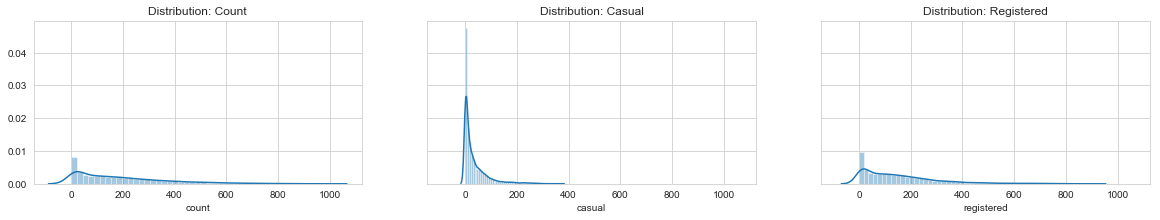

In [18]:
# Visualizing the distribution of potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 3), sharex=True, sharey=True)

sns.distplot(train_set['count'], ax=axes[0])
sns.distplot(train_set['casual'], ax=axes[1])
sns.distplot(train_set['registered'], ax=axes[2])

axes[0].set_title('Distribution: Count')
axes[1].set_title('Distribution: Casual')
axes[2].set_title('Distribution: Registered');

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


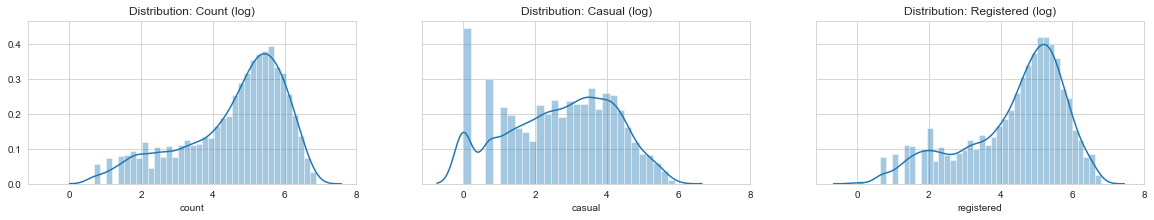

In [19]:
# Visualizing the distribution of our potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 3), sharex=True, sharey=True)

sns.distplot(np.log1p(train_set['count']), ax=axes[0])
sns.distplot(np.log1p(train_set['casual']), ax=axes[1])
sns.distplot(np.log1p(train_set['registered']), ax=axes[2])

axes[0].set_title('Distribution: Count (log)')
axes[1].set_title('Distribution: Casual (log)')
axes[2].set_title('Distribution: Registered (log)');

#### Notes:
- For casual, the # of bikes being used has a huge spike in the low-end
- For registered, the distribution is more flat (indicating that registered users are more common at a daily level)
- We are better calculating the log.1p to get a normal distribution. 

A logistic distribution better represents the data when the data is highly skewed. For example, if our data contained values like 0, 1, 10, and 100, well our data will be skewed by the 100. When transforming 0, 1, 10, and 100 in a logistic distrbution, we are normalizing the increases from 0, 1, 10, and 100:

```python
log_transform = [np.log1p(i) for i in [0, 1, 10, 100]]
log_transform    
    
# Output: [0.0, 0.6931471805599453, 2.3978952727983707, 4.61512051684126]
```

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


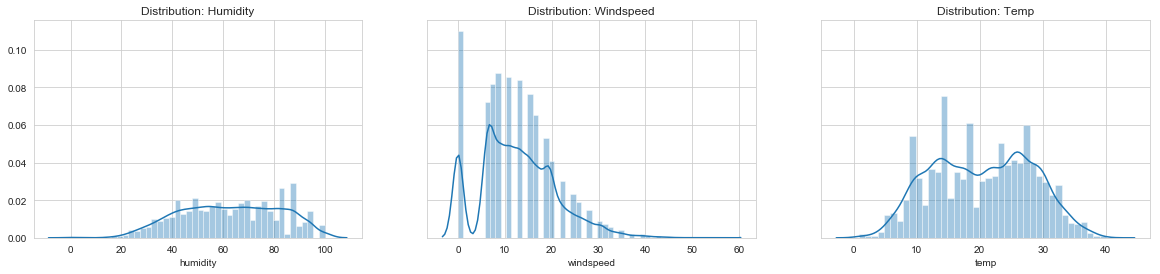

In [20]:
# Lets visualize the distribution of the windspeed, humidity, temp

fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True)

sns.distplot(data['humidity'], ax=axes[0])
sns.distplot(data['windspeed'], ax=axes[1])
sns.distplot(data['temp'], ax=axes[2])

axes[0].set_title('Distribution: Humidity')
axes[1].set_title('Distribution: Windspeed')
axes[2].set_title('Distribution: Temp');

In [89]:
data.dtypes

datetime              datetime64[ns]
season                         int64
holiday                        int64
workingday                     int64
weather                        int64
temp                         float64
humidity                       int64
windspeed                    float64
data_source                    int64
Year                           int64
Month                          int64
Week                           int64
Day                            int64
Dayofweek                      int64
Dayofyear                      int64
Days_in_month                  int64
is_leap_year                   int64
Is_month_end                   int64
Is_month_start                 int64
Is_quarter_end                 int64
Is_quarter_start               int64
Is_year_end                    int64
Is_year_start                  int64
Hour                           int64
Minute                         int64
Second                         int64
frac_week                    float64
f

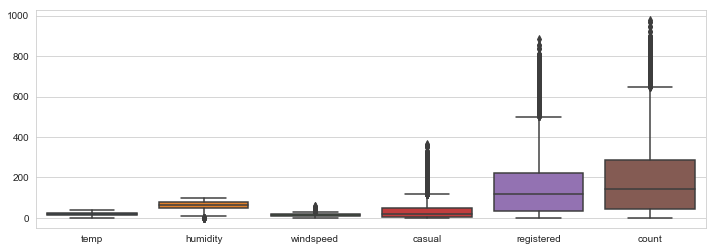

In [96]:
# Visualizing boxplots
plt.figure(figsize=(12,4))
sns.boxplot(data=train_set[['temp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])
plt.show()

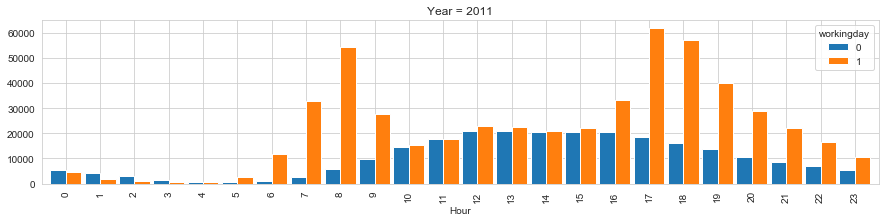

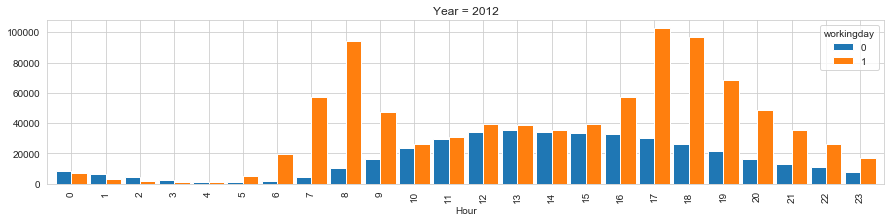

In [21]:
plot_by_hour('workingday', 'count', year=2011)
plot_by_hour('workingday', 'count', year=2012)

#### Notes:
- Notice that we see there is an increase during peak hours in 2011 and 2012. 

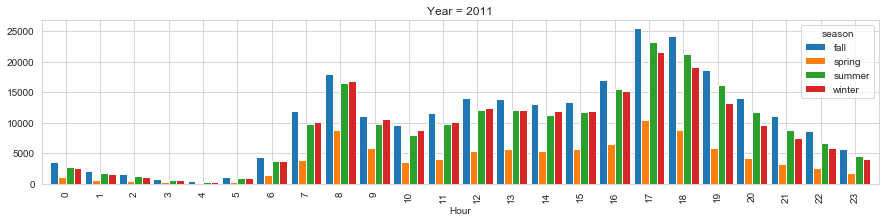

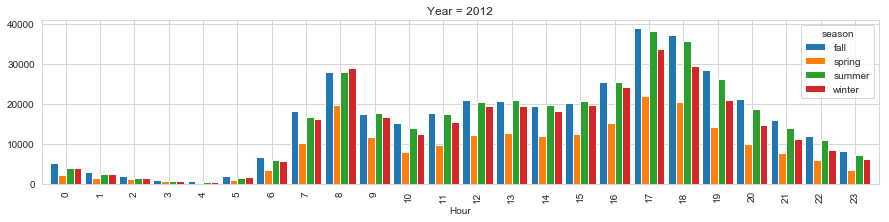

In [22]:
plot_by_hour('season', 'count', year=2011)
plot_by_hour('season', 'count', year=2012)

#### Notes
- Every season has a similar trend except for the spring
    -  1 = spring, 2 = summer, 3 = fall, 4 = winter 


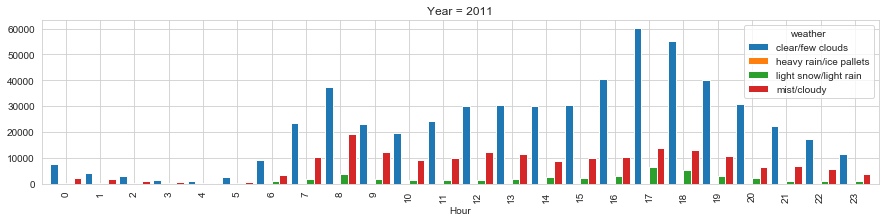

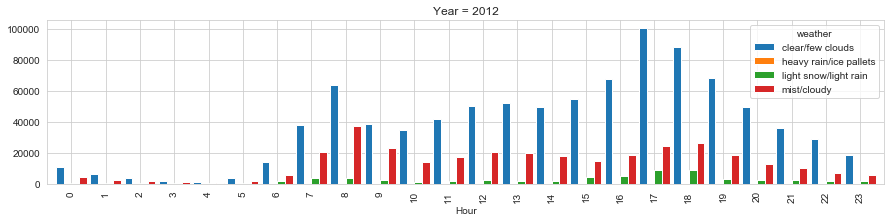

In [23]:
# - weather 
#    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
#    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
#    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
#    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

plot_by_hour('weather', 'count', year=2011)
plot_by_hour('weather', 'count', year=2012)

#### Notes:
- The season and weather visualization states that:
    - All season follow a similar distribution along the x-axis (hours) but spring is has a signficant lesser count
    - A clear weather attracts more people (higher count)

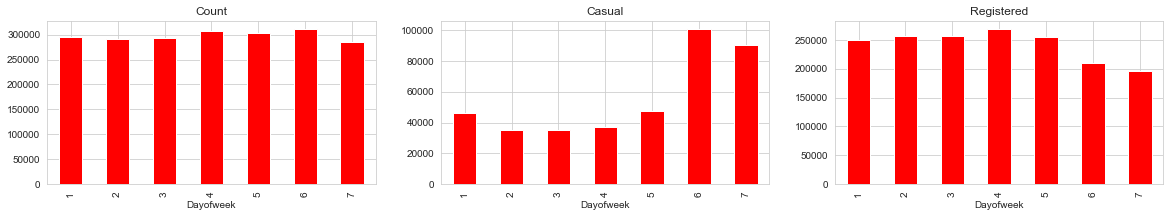

In [24]:
data['Dayofweek'] = data['Dayofweek'].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, 
                                           "Friday": 5, "Saturday": 6,  "Sunday": 7})

fig, axs = plt.subplots(1, 3, figsize=(20, 3))

data.groupby('Dayofweek')['count'].sum().sort_index().plot.bar(color='R', ax=axs[0])
data.groupby('Dayofweek')['casual'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[1])
data.groupby('Dayofweek')['registered'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[2])

axs[0].set_title('Count')
axs[1].set_title('Casual')
axs[2].set_title('Registered');

#### Notes:
- Casual users are more common in the weekend while registered users are more common in the weekdays

## Data Cleaning

In [25]:
np.warnings.filterwarnings('ignore')

data['casual_log'] = np.log1p(data['casual'])
data['registered_log'] = np.log1p(data['registered'])
data['count_log'] = np.log1p(data['count'])

data.drop(['casual', 'registered', 'count'], axis=1, inplace=True)

## Model Selection: Correlation

In [26]:
PREDICTORS = ['casual_log', 'registered_log', 'count_log']

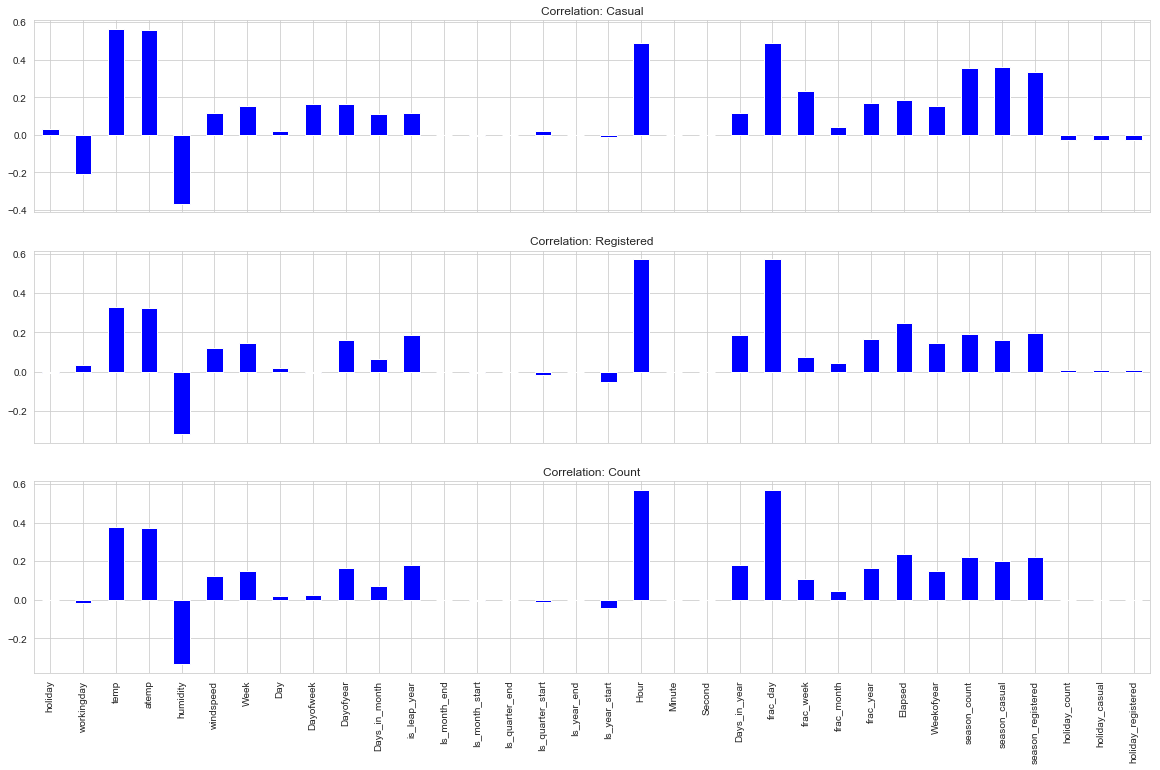

In [27]:
# Correlation among the variables and the potential predictors
corrs = data.corr()

fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
corrs['casual_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[0], title="Correlation: Casual");
corrs['registered_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[1], title="Correlation: Registered");
corrs['count_log'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[2], title="Correlation: Count");

#### Notes:
- The top correlated variables with the predictors are Hour, Days_in_year, frac_day, Elapsed
- The correlation values are similar throughout the three predictors with the exception of workingday

In [28]:
def correlation(data, corr_by, remove_by=None, top_values=10):
    data = data.copy()
    corrs = data.corr()
    if remove_by is None: remove_by = [corr_by]     
        
    vals = corrs[corr_by].drop(remove_by).sort_values().values
    col = corrs[corr_by].drop(remove_by).sort_values().index
    
    df = pd.DataFrame({'columns': col, 'values': vals})
    df['abs_vals'] = abs(df['values'])
    
    return df.sort_values(by='abs_vals', ascending=False)[:top_values]

In [29]:
correlation(data, 'casual_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,temp,0.562596,0.562596
27,atemp,0.559950,0.559950
26,frac_day,0.486784,0.486784
25,Hour,0.486784,0.486784
0,humidity,-0.366263,0.366263
24,season_casual,0.362035,0.362035
23,season_count,0.353901,0.353901
22,season_registered,0.332353,0.332353
21,frac_week,0.232573,0.232573
1,workingday,-0.208715,0.208715


In [30]:
correlation(data, 'registered_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,Hour,0.572704,0.572704
27,frac_day,0.572704,0.572704
26,temp,0.330701,0.330701
25,atemp,0.326022,0.326022
0,humidity,-0.317667,0.317667
24,Elapsed,0.246150,0.246150
23,season_registered,0.196908,0.196908
22,season_count,0.192971,0.192971
21,is_leap_year,0.189234,0.189234
20,Days_in_year,0.189234,0.189234


In [31]:
correlation(data, 'count_log', remove_by=PREDICTORS)

,columns,values,abs_vals
28,Hour,0.570638,0.570638
27,frac_day,0.570638,0.570638
26,temp,0.376587,0.376587
25,atemp,0.372167,0.372167
0,humidity,-0.333158,0.333158
24,Elapsed,0.237444,0.237444
23,season_count,0.223818,0.223818
22,season_registered,0.223127,0.223127
21,season_casual,0.200552,0.200552
20,is_leap_year,0.178236,0.178236


## Data Cleaning: Removing Columns

#### Notes:
- After checking the correlations values, there are a couple of columns that represent the same information. Some of the redudant columns are:
    - Hour and frac_day
    - temp and atemp
    - Days_in_year and is_leap_year

In [32]:
data.drop(['frac_day', 'atemp', 'Days_in_year'], axis=1, inplace=True)

## Data Cleaning: Encoding Columns

To labelencode categorical variables, we will be using `LabelEncoder()`

In [33]:
from sklearn import preprocessing

# Extracting the columns that will be encoded
object_cols = data.select_dtypes('object').columns.tolist()
bool_cols = data.select_dtypes('bool').columns.tolist()
encoded_cols = object_cols+bool_cols

from collections import defaultdict

d = defaultdict(preprocessing.LabelEncoder)
data[encoded_cols] = data[encoded_cols].apply(lambda x: d[x.name].fit_transform(x))

## Feature Enginnering

In [ ]:
data['hr_sin'] = np.sin(data['Hour']*(2.*np.pi/24))
data['hr_cos'] = np.cos(data['Hour']*(2.*np.pi/24))
data['mnth_sin'] = np.sin((data['Month']-1)*(2.*np.pi/12))
data['mnth_cos'] = np.cos((data['Month']-1)*(2.*np.pi/12))

In [103]:
'''train_on['hr_sin'] = np.sin(train_on['Hour']*(2.*np.pi/24))
train_on['hr_cos'] = np.cos(train_on['Hour']*(2.*np.pi/24))
train_on['mnth_sin'] = np.sin((train_on['Month']-1)*(2.*np.pi/12))
train_on['mnth_cos'] = np.cos((train_on['Month']-1)*(2.*np.pi/12))

test_on['hr_sin'] = np.sin(test_on['Hour']*(2.*np.pi/24))
test_on['hr_cos'] = np.cos(test_on['Hour']*(2.*np.pi/24))
test_on['mnth_sin'] = np.sin((test_on['Month']-1)*(2.*np.pi/12))
test_on['mnth_cos'] = np.cos((test_on['Month']-1)*(2.*np.pi/12))'''

## Data Modeling

In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# There are some internal error with Xgboost, this is the way around it
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/alexguanga/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
sum_count = train_set['count'].sum()
sum_casual = train_set['casual'].sum()
sum_registered = train_set['registered'].sum()

In [36]:
# A rough estimate of our weights to casual & registered
print(f"Casual to Count Ratio: {sum_casual/sum_count:.2f}")
print(f"Registered to Count Ratio: {sum_registered/sum_count:.2f}")

Casual to Count Ratio: 0.19
Registered to Count Ratio: 0.81


In [37]:
# Will need the test_datetime when we are submitting the predictions
test_datetime = data.loc[data['count_log'].isnull(), "datetime"]

# Returns the target variable for the training set
def get_train_labels(data, predictors):
    labels = [np.array(list(data.loc[data[p].notnull(), p])) for p in predictors]
    return labels

In [38]:
# Extracting the target variable without encoding(we will have 3 for this dataset)
train_label_cnt, train_label_reg, train_label_cas = get_train_labels(
    data, ['count_log', 'registered_log', 'casual_log'])

In [39]:
# Columns that will be dropped from the dataset (predictors & time)
cols_to_drop = ['count_log', 'registered_log', 'casual_log', 'datetime',]

# Calculating the training set for the two dataframes 
train_on = data.loc[data['count_log'].notnull()]
train_on.drop(cols_to_drop, axis=1, inplace=True)

# Calculating the testing set for the two dataframes
test_on = data.loc[data['count_log'].isnull()]
test_on.drop(cols_to_drop, axis=1, inplace=True)

In [40]:
print(f"The shape of the training set (without encoders) is {train_on.shape}")

The shape of the training set (without encoders) is (10886, 40)


In [41]:
# Custom scorer that will be used to measure performance
def rmse(actual, predicted):        
    assert len(actual) == len(predicted)
    return np.sqrt(np.mean(np.power((actual)-(predicted), 2)))

def rmse_log(actual, predicted):
    assert len(actual) == len(predicted)
    sle = (np.power(np.log(np.array((actual))+1) - np.log(np.array(np.abs(predicted))+1), 2))
    msle = np.mean(sle)
    return np.sqrt(msle)

In [42]:
scorer = make_scorer(rmse_log, greater_is_better=False)

In [43]:
MODELS = {"Random Forest": RandomForestRegressor(n_jobs=-1),
          "XGBoost": xgb.XGBRegressor(n_jobs=-1), 
          "Gradient Boosting": GradientBoostingRegressor()}

In [44]:
def run_models_cv(data, labels, model, cv=10):
    cv_score = cross_val_score(model, data, labels, cv=cv, scoring=scorer)
    print(f"10-Fold CV RMSE = {round(np.abs(cv_score.mean()), 4)} & Std. deviation = {round(cv_score.std(), 4)}")

In [100]:
for model_name, model in MODELS.items():
    print(f"{model_name}")
    run_models_cv(train_on, train_label_cnt, model)
    print("----------")
    

Random Forest
10-Fold CV RMSE = 0.0986 & Std. deviation = 0.0266
----------
XGBoost
10-Fold CV RMSE = 0.0954 & Std. deviation = 0.0221
----------
Gradient Boosting
10-Fold CV RMSE = 0.0965 & Std. deviation = 0.0248
----------


#### Notes
- I would like to use all theree target variables to make predictions.
- However, finding the appropriate weight to each of the target variables is more complicated than it seems.
- I am going to make two prediction (to gain a better understanding of their performance)
    1. Add the Casual + Registered predictions
    2. Use the Count predictions

In [46]:
def feat_df(feats, cols):
    return pd.DataFrame(feats, index=cols, columns=['importance']).sort_values('importance', ascending=False)

def get_predict(model, train_on, train_labels, test_on, test_ids):
    model.fit(train_on, train_labels)
    
    predict = model.predict(test_on)
    predict = np.exp(predict) - 1
    
    sub = pd.DataFrame({'datetime': test_ids, 'count': predict.astype(int)})
    return sub

def random_search(model, params, train_on, train_labels, cv=5):
    train_on = train_on.values
    rs = RandomizedSearchCV(model, param_distributions=params, scoring=scorer, cv=cv)
    
    # Train the model
    rs.fit(train_on, train_labels)
    return rs

In [54]:
def run_model(model_1, model_2, params, train_on):
    train_on = train_on.copy()
    train_labels = {'Train (Count)': train_label_cnt, 
                    'Train (Reg)': train_label_reg,
                    'Train (Casual)': train_label_cas}
    
    columns = train_on.columns
    
    params_feat, params_all = {}, {}
    predict_feat, predict_all = {}, {}
    
    for label_name, train_label in train_labels.items():
        
        model_search = random_search(model_1, params, train_on, train_label, cv=5)
        best_params, best_score = model_search.best_params_, model_search.best_score_
        
        print(f"Best Params. for {str(label_name)} (all-in columns): {best_params}")
        print(f"Best Score for {str(label_name)} (all-in columns): {np.abs(best_score):.2f}")
        params_feat[str(label_name)] = best_params
        
        model = model_2(**best_params)
        model.fit(train_on, train_label)
        
        # Creating predictions with all variables
        predict = get_predict(model, train_on, train_label, test_on, test_datetime)
        predict_all[str(label_name)] = predict
        
        imp_cols = feat_df(model.feature_importances_, columns)
        imp_cols = imp_cols[imp_cols['importance'] > 0].index
        
        model_search = random_search(model_1, params, train_on[imp_cols], train_label, cv=5)
        best_params, best_score = model_search.best_params_, model_search.best_score_
              
        print(f"Best Params. for {str(label_name)} (feat. selection): {best_params}")
        print(f"Best Score for {str(label_name)} (feat. selection): {np.abs(best_score):.2f}\n")
        params_all[str(label_name)] = best_params
        
        model = model_2(**best_params)
        model.fit(train_on, train_label)
        
        # Creating predicition with the feature selections
        predict = get_predict(model, train_on[imp_cols], train_label, test_on[imp_cols], test_datetime)
        predict_feat[str(label_name)] = predict
    
    return [params_feat, params_all, predict_feat, predict_all] 

In [55]:
xgb_model_1 = xgb.XGBRegressor(n_jobs=-1)
xgb_model_2 = xgb.XGBRegressor
xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight": [1, 3, 5, 7],
              "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree": [0.3, 0.4, 0.5 , 0.7]}

In [107]:
xgb_feat_param, xgb_all_param, xgb_feat_predict, xgb_all_predict = run_model(xgb_model_1, xgb_model_2, 
                                                                             xgb_params, train_on)

Best Params. for Train (Count) (all-in columns): {'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}
Best Score for Train (Count) (all-in columns): 0.10
Best Params. for Train (Count) (feat. selection): {'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.4}
Best Score for Train (Count) (feat. selection): 0.09

Best Params. for Train (Reg) (all-in columns): {'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}
Best Score for Train (Reg) (all-in columns): 0.10
Best Params. for Train (Reg) (feat. selection): {'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.7}
Best Score for Train (Reg) (feat. selection): 0.10

Best Params. for Train (Casual) (all-in columns): {'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.5}
Best Score for Train (Casual) (all-in col

In [108]:
xgb_all_predict['Train (Count)'].to_csv("./saved_submissions/xgb-all_12-26-18.csv", index=False)
xgb_feat_predict['Train (Count)'].to_csv("./saved_submissions/xgb-feat_12-26-18.csv", index=False)

In [109]:
# Registered+Casual submission
xgb_predict = (xgb_all_predict['Train (Casual)']['count'] + xgb_all_predict['Train (Reg)']['count']).astype(int)
xgb_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': xgb_predict.astype(int)})
xgb_sum_submit.to_csv("./saved_submissions/xgb-all-sum_12-26-18.csv", index=False)

# Registered+Casual submission
xgb_predict = (xgb_feat_predict['Train (Casual)']['count'] + xgb_feat_predict['Train (Reg)']['count']).astype(int)
xgb_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': xgb_predict.astype(int)})
xgb_sum_submit.to_csv("./saved_submissions/xgb-feat-sum_12-26-18.csv", index=False)

#### Notes:
- One thing to keep in ind is that I am creating the logistic transformation on the predictor variables. However, I am also calculating the error on the predictors.

#### Scoring: (remove cyclical datetimes for the first result)
- `xgb_all_predict['Train (Count)']` = 0.44661 (0.42405)
- `xgb_feat_predict['Train (Count)']` = 0.42318 (0.43072)
- `xgb_sum` (all-in) = 0.41750 (0.42528)
- `xgb_sum` (feat) = 0.43735 (0.42444)

In [59]:
gb_model_1 = GradientBoostingRegressor()
gb_model_2 = GradientBoostingRegressor
gb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
             "n_estimators": [32, 64, 100, 150, 200],
             "max_depth": np.linspace(1, 32, 32, endpoint=True),
             "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
             "min_samples_leaf": [2, 4, 6, 8, 10, 12, 14]}

In [60]:
gb_feat_param, gb_all_param, gb_feat_predict, gb_all_predict = run_model(gb_model_1, gb_model_2, 
                                                                         gb_params, train_on)

Best Params. for Train (Count) (all-in columns): {'n_estimators': 100, 'min_samples_split': 0.1, 'min_samples_leaf': 4, 'max_depth': 4.0, 'learning_rate': 0.3}
Best Score for Train (Count) (all-in columns): 0.10
Best Params. for Train (Count) (feat. selection): {'n_estimators': 32, 'min_samples_split': 0.1, 'min_samples_leaf': 2, 'max_depth': 20.0, 'learning_rate': 0.3}
Best Score for Train (Count) (feat. selection): 0.10

Best Params. for Train (Reg) (all-in columns): {'n_estimators': 150, 'min_samples_split': 0.2, 'min_samples_leaf': 8, 'max_depth': 14.0, 'learning_rate': 0.25}
Best Score for Train (Reg) (all-in columns): 0.10
Best Params. for Train (Reg) (feat. selection): {'n_estimators': 150, 'min_samples_split': 0.1, 'min_samples_leaf': 4, 'max_depth': 19.0, 'learning_rate': 0.3}
Best Score for Train (Reg) (feat. selection): 0.10

Best Params. for Train (Casual) (all-in columns): {'n_estimators': 64, 'min_samples_split': 0.2, 'min_samples_leaf': 14, 'max_depth': 18.0, 'learning_r

In [61]:
gb_all_predict['Train (Count)'].to_csv("./saved_submissions/gb-all_12-26-18.csv", index=False)
gb_feat_predict['Train (Count)'].to_csv("./saved_submissions/gb-feat_12-26-18.csv", index=False)

In [62]:
# Registered+Casual submission
gb_predict = (gb_all_predict['Train (Casual)']['count'] + gb_all_predict['Train (Reg)']['count']).astype(int)
gb_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': gb_predict.astype(int)})
gb_sum_submit.to_csv("./saved_submissions/gb-all-sum_12-26-18.csv", index=False)

# Registered+Casual submission
gb_predict = (gb_feat_predict['Train (Casual)']['count'] + gb_feat_predict['Train (Reg)']['count']).astype(int)
gb_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': gb_predict.astype(int)})
gb_sum_submit.to_csv("./saved_submissions/gb-feat-sum_12-26-18.csv", index=False)


#### Scoring:
- `gb_all_predict['Train (Count)']` = 0.43955
- `gb_feat_predict['Train (Count)']` = 0.45066
- `gb_sum` (all-in) = 0.45338
- `gb_sum` (feat) = 0.44531

In [85]:
rf_model_1 = RandomForestRegressor(n_jobs=-1)
rf_model_2 = RandomForestRegressor
rf_params = {"n_estimators": [int (x) for x in np.linspace(start=200, stop=1000, num=9, endpoint=True)],
             "max_features": ['auto', 'sqrt'],
             "max_depth": np.linspace(5, 32, 28, endpoint=True),
             "min_samples_split": np.linspace(0.1, 1.0, 10, endpoint=True),
             "min_samples_leaf": [4, 6, 8, 10, 12, 20]}

In [86]:
rf_feat_param, rf_all_param, rf_feat_predict, rf_all_predict = run_model(rf_model_1, rf_model_2, 
                                                                         rf_params, train_on)

Best Params. for Train (Count) (all-in columns): {'n_estimators': 900, 'min_samples_split': 0.1, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 25.0}
Best Score for Train (Count) (all-in columns): 0.17
Best Params. for Train (Count) (feat. selection): {'n_estimators': 300, 'min_samples_split': 0.6, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 22.0}
Best Score for Train (Count) (feat. selection): 0.21

Best Params. for Train (Reg) (all-in columns): {'n_estimators': 400, 'min_samples_split': 0.2, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 18.0}
Best Score for Train (Reg) (all-in columns): 0.20
Best Params. for Train (Reg) (feat. selection): {'n_estimators': 600, 'min_samples_split': 0.6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 6.0}
Best Score for Train (Reg) (feat. selection): 0.21

Best Params. for Train (Casual) (all-in columns): {'n_estimators': 1000, 'min_samples_split': 0.1, 'min_samples_leaf': 12, 'max_features': '

In [87]:
rf_all_predict['Train (Count)'].to_csv("./saved_submissions/rf-all_12-26-18.csv", index=False)
rf_feat_predict['Train (Count)'].to_csv("./saved_submissions/rf-feat_12-26-18.csv", index=False)

In [88]:
# Registered+Casual submission
rf_predict = (rf_all_predict['Train (Casual)']['count'] + rf_all_predict['Train (Reg)']['count']).astype(int)
rf_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': rf_predict.astype(int)})
rf_sum_submit.to_csv("./saved_submissions/rf-all-sum_12-26-18.csv", index=False)

# Registered+Casual submission
rf_predict = (rf_feat_predict['Train (Casual)']['count'] + rf_feat_predict['Train (Reg)']['count']).astype(int)
rf_sum_submit = pd.DataFrame({'datetime': test_datetime, 'count': rf_predict.astype(int)})
rf_sum_submit.to_csv("./saved_submissions/rf-feat-sum_12-26-18.csv", index=False)

#### Scoring:
- `rf_all_predict['Train (Count)']` = 
- `rf_feat_predict['Train (Count)']` = 0.76408
- `rf_sum` (all-in) = 0.79640
- `rf_sum` (feat) = 0.85858

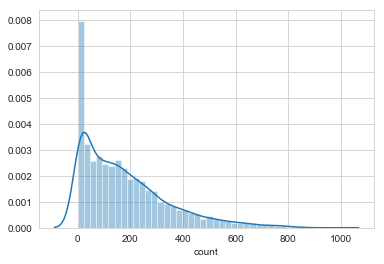

In [150]:
sns.distplot(xgb_predict['Train (Count)']['count'])

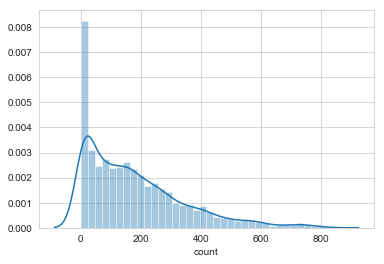

In [149]:
sns.distplot(xgb_sum_predict.astype(int))

In [141]:
gb_predict['Train (Casual)']['count'].value_counts()

0      538
1      460
2      292
3      266
4      195
5      164
6      163
7      157
9      133
8      128
11     117
10     115
12     114
16     107
18     101
13      93
14      87
17      85
19      84
15      84
22      74
23      72
21      68
25      68
24      65
38      60
29      58
28      58
31      57
32      56
      ... 
214      1
226      1
238      1
278      1
314      1
192      1
239      1
139      1
171      1
175      1
179      1
219      1
170      1
138      1
275      1
269      1
245      1
241      1
229      1
221      1
209      1
169      1
161      1
255      1
324      1
304      1
300      1
236      1
232      1
279      1
Name: count, Length: 244, dtype: int64

## Data Submission

# TODO: run the funciton above and claulcate new predciton with weights

https://github.com/logicalguess/kaggle-bike-sharing-demand/blob/master/code/main.ipynb